In [1]:
import math
import os
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
import seaborn as sns;
from scipy.stats import f_oneway

In [3]:
eq0 = False
emotionnel = False

In [4]:
colors = "coolwarm"

In [5]:
def webfrac(x=1,nb=5, k = 0.9):
    """
    Trouve une valeur Z tel que la weberFraction(x,y)=weberFraction(y,z)
    Valeur de référence : a distance de 15, il faut au moins une seconde distance de 18 pour differencier
    """
    
    
    res = [x]
    for i in range(nb-1):
        res.append(round(res[-1]*k+res[-1]))
    return res

In [6]:
dists = webfrac(5,5,k=0.7)
dists
logs=True

In [7]:
def convertDistanceAngleEnPosition(angle,distance, ecartDistance = 5, logs = False, dist = []):
    if(logs):
        r = dist[distance]
    else:
        r = distance*ecartDistance
    #Shift pour lisibilité : Pour la simulation 0° est devant 90° est a gauche
    angle = angle-90
    posX = r*math.cos(math.radians(angle))
    posY = r*math.sin(math.radians(angle))
    return (round(posX),round(posY))


In [8]:
def calculPositionDisponibles(nombreAngle = 7,nombreDistance=5, espaceDistance = 5, logs = False, dist = dists, posDict = True,angle=False):
    """Détermine l'ensemble des positions disponibles en fonctions du nombre d'angles et de cercles de positionnement accessible"""
    position = dict()
    positionGroupe = dict()
    deltaAngle = 180 / (nombreAngle - 1)
    if(logs):
        if(not angle):
            for d in range(0,len(dist)):
                position[d] = []
                for a in range(0, nombreAngle):
                    angle = a * deltaAngle
                    x,y = convertDistanceAngleEnPosition(angle,d,logs=logs,dist=dist)
                    if(posDict):
                        position[d].append((round(x),round(y)))
                    else:
                        positionGroupe[str(x)+"_"+str(y)] = [d,int(angle)]
        else:
            for a in range(0,nombreAngle):
                position[a * deltaAngle] = []
                for d in range(0, len(dist)):
                    angle = a * deltaAngle
                    x,y = convertDistanceAngleEnPosition(angle,d,logs=logs,dist=dist)
                    if(posDict):
                        position[a * deltaAngle].append((round(x),round(y)))
                    else:
                        positionGroupe[str(x)+"_"+str(y)] = [d,int(angle)]
            
    else:
        if(not angle):
            for d in range(1,nombreDistance+1):
                position[d] = []
                for a in range(0, nombreAngle):
                    angle = a * deltaAngle
                    x,y = convertDistanceAngleEnPosition(angle,d)
                    if(posDict):
                        position[d].append((round(x),round(y)))
                    else:
                        positionGroupe[str(x)+"_"+str(y)] = [d,int(angle)]
        else:
            for a in range(0,nombreAngle):
                position[a* deltaAngle]=[]
                for d in range(1,nombreDistance+1):
                    angle = a * deltaAngle
                    x,y = convertDistanceAngleEnPosition(angle,d)
                    if(posDict):
                        position[a* deltaAngle].append((round(x),round(y)))
                    else:
                        positionGroupe[str(x)+"_"+str(y)] = [d,int(angle)]
                    
    if(posDict):
        return position
    else:
        return positionGroupe

In [9]:
calculPositionDisponibles(logs=True,angle=True)

{0.0: [(0, -5), (0, -8), (0, -14), (0, -24), (0, -41)],
 30.0: [(3, -4), (4, -7), (7, -12), (12, -21), (21, -36)],
 60.0: [(4, -2), (7, -4), (12, -7), (21, -12), (36, -20)],
 90.0: [(5, 0), (8, 0), (14, 0), (24, 0), (41, 0)],
 120.0: [(4, 2), (7, 4), (12, 7), (21, 12), (36, 20)],
 150.0: [(3, 4), (4, 7), (7, 12), (12, 21), (21, 36)],
 180.0: [(0, 5), (0, 8), (0, 14), (0, 24), (0, 41)]}

In [10]:
def convertirPositionEnDistance(x,y,verbose = False):
    pos = calculPositionDisponibles(logs=logs,dist=dist)
    for d in pos.keys():
        for i,j in pos[d]:
            if(i == x and j == y):
                if(verbose):
                    print("Distance : "+str(d))
                return d
def convertirPositionEnDistance(string,verbose = False,logs=False,dist=[]):
    string= string.split("_")
    x=int(string[0])
    y=int(string[1])
    pos = calculPositionDisponibles(logs=logs,dist=dist)
    for d in pos.keys():
        for i,j in pos[d]:
            if(i == x and j == y):
                if(verbose):
                    print("Distance : "+str(d))
                return d
    return -1

In [11]:
def convertPositionEnAngleDistance(x,y):
    d = math.sqrt(x**2+y**2)#Calcul de distance ok a +- 1 
    cosrada = x/d
    sinrada = y/d
    radax = math.acos(cosrada)
    raday = math.asin(sinrada)
    ax = math.degrees(radax)
    ay = math.degrees(raday)
    #print(round(ax),round(ay))
    return round(ay),round(d)

In [12]:
def getFileName(subjectName, emotionnel,date=""):
    folderBack = True
    if(folderBack):
            logfileDirectory = "LogFiles\\"
    else:
        logfileDirectory = "Experience Fiabilité\\LogFile\\"
    subjectName+=date
    fileNameExtension = "ReponseStimuli"+"Emotionnel"*emotionnel+".txt"
    logfileName = logfileDirectory+subjectName+fileNameExtension
    return logfileName

In [13]:
def extractResults(subjectName="",emotionnel=False,date="",fileName = ""):
    if(fileName == ""):
        logfileName = getFileName(subjectName,emotionnel,date)
    else:
        logfileName = fileName
    verboseDetail = False
    diagonales = False
    deplacements = ["Approche Gauche","Approche","Approche Droite","Gauche","Aucun","Droite","Eloignement Gauche","Eloignement","Eloignement Droite"]
    reponses = dict()
    bonnesReponses = [0,0,0,0,0,0,0,0,0]
    mauvaisesReponses = [0,0,0,0,0,0,0,0,0]
    resultatsDistances = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    resultatsDistances2 = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
    deplacementsDistance = [[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],[[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]]
    certainty = []
    logfile = open(logfileName,'r')
    log = logfile.read()
    trials = log.split("Fin")
    repPreCert = []
    for t in trials:
        dist = -1
        dist2 = -1
        lines = t.split("\n")
        reponseCorrecte = 0
        expected = -1
        rt = -1
        cert = -1
        rtcert = -1
        nTrial = -1
        posDistance = -1
        posCorrecte = -1
        p1 = -1
        p2 = -1
        pSelec = -1
        for i in lines:
            if("trial" in i): #Determine le n° de l'etape
                s = i.split(" ")
                nTrial = int(s[-1])
                if(verboseDetail):
                    print("Etape "+s[-1])
            elif("Reponse" in i):#Etudie la réponse donnée
                sp = i.split(" ")
                inp = int(sp[1])
            elif("Mouvement" in i):
                sp = i.split(" ")
                expected = int(sp[1])

            elif("Position1" in i):#Détermine la position initiale
                pos1 = i.split(" ")[1]
                p1 = pos1.split("_")
                p1 = (int(p1[0]),int(p1[1]))
                a,dist = convertPositionEnAngleDistance(p1[0],p1[1]) 
            elif("Position2" in i):#Détermine la position initiale
                pos2 = i.split(" ")[1]
                p2 = pos2.split("_")
                p2 = (int(p2[0]),int(p2[1]))
                a,dist2 = convertPositionEnAngleDistance(p2[0],p2[1]) 
            elif("ReactionTime" in i):
                if("ReactionTimeCertainty" in i):
                    rtcert = int(i.split(" ")[1])
                else:
                    rt = int(i.split(" ")[1])
            elif("Certainty" in i):
                    cert = int(i.split(" ")[1])
        repPreCert.append((inp,expected))
        if(p1 != -1):
            if(p1[0] not in reponses.keys()):
                reponses[p1[0]] = dict()
            if(p1[1] not in reponses[p1[0]].keys()):
                reponses[p1[0]][p1[1]] = dict()
            if(inp-1 <=9):
                reponses[p1[0]][p1[1]][deplacements[expected-1]] = dict()
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["Reponse"] = inp
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["idMouvement"] = expected
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["ReactionTime"] = rt
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["Numero"] = nTrial
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["P2"] = p2
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["D1"] = dist
                reponses[p1[0]][p1[1]][deplacements[expected-1]]["D2"] = dist2
        if(cert != -1 and rtcert != -1):
            certainty.append((cert,rtcert,repPreCert))
            reponses[p1[0]][p1[1]][deplacements[expected-1]]["Cert"] = cert
            repPreCert = []
    return reponses,certainty

In [14]:
def combineLogs(subjectName="",emotionnel=False,date = "",fileName = "",r = []):
    mouvements = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    if(r == []):
        r = dict()
        for length in range(0,51):
            r[length] = dict()
            for width in range(-50,51):
                r[length][width] = dict()
                for m in mouvements:
                    r[length][width][m] = []
    res,cert = extractResults(subjectName,emotionnel,date,fileName = fileName)
    for x in res.keys():
        for y in res[x].keys():
            for mvm in res[x][y].keys():
                d = dict()
                d['Reponse'] = res[x][y][mvm]['Reponse']
                if(d['Reponse'] > 3 or d['Reponse'] < -3):
                    d['Reponse'] = 0
                d['ReactionTime'] = res[x][y][mvm]['ReactionTime']
                d['D1'] = res[x][y][mvm]['D1']
                d['D2'] = res[x][y][mvm]['D2']
                d['P2'] = res[x][y][mvm]['P2']
                d['Numero'] = res[x][y][mvm]['Numero']
                d['Subject'] = subjectName
                if(cert in list(res[x][y][mvm].keys())):
                    d['Cert'] = res[x][y][mvm]['Cert'] 
                if(emotionnel):
                    d['Type'] = "Emotionnel"
                else:
                    d['Type'] = "Mouvement"
                r[x][y][mvm].append(d)
                
    return r,cert

In [15]:
def collectLogs(allowEmotionnel = False,onlyEmotionnel = False,sans=[],specific = "",verbose = False):
    res = []
    subjectList = []
    subjectCert = dict()
    if(specific == ""):
        for file in os.listdir('LogFiles'):
            if("Emotionnel" in file and not allowEmotionnel):
                if(verbose):
                    print("Skip")
            else:
                subjectName = file.replace(".txt","")
                if("ReponseStimuli" in file and "Calib" not in file and (("Emotionnel" in file and onlyEmotionnel) or not onlyEmotionnel)):
                    if(verbose):
                        print(file)
                    subjectName = subjectName.replace("ReponseStimuli","")
                    em = False
                    if("Emotionnel" in file):
                        em=True
                        subjectName = subjectName.replace("Emotionnel","")

                    if(subjectName in sans):
                        if(verbose):
                            print("Excluded")
                    else:
                        subjectList.append(subjectName)
                        res,cert = combineLogs(fileName='LogFiles\\'+file,emotionnel = em,subjectName=subjectName,r=res)
                        subjectCert[subjectName]=cert
                        if(verbose):
                            print("Name : "+subjectName)
    else:
        for file in os.listdir('LogFiles'):
            subjectName = file.replace(".txt","")
            if("ReponseStimuli" in file and "Calib" not in file):
                if(verbose):
                    print(file)
                subjectName = subjectName.replace("ReponseStimuli","")
                em = False
                if("Emotionnel" in file):
                    em=True
                    subjectName = subjectName.replace("Emotionnel","")

                if(subjectName in specific):
                    subjectList.append(subjectName)
                    res,cert = combineLogs(fileName='LogFiles\\'+file,emotionnel = em,subjectName=subjectName,r=res)
                    subjectCert[subjectName]=cert
                    if(verbose):
                        print("Name : "+subjectName)
    return res,subjectCert,subjectList

In [16]:
sa = ['Annick','Maet']
emo = ['Adele','Etienne','Hippolyte','Sophie','Corisande']
#sa = ['Manu']
onlyEmotionnel = emotionnel
allowEmotionnel = emotionnel
if(not onlyEmotionnel and not allowEmotionnel):
    sa +=emo
specific = ""
#specific = "EtienneSophie"
res,subjectCert,subjectList = collectLogs(allowEmotionnel = True,onlyEmotionnel = onlyEmotionnel,sans = sa,verbose=True,specific = specific)

AchilleReponseStimuli.txt
Name : Achille
AdeleReponseStimuliEmotionnel.txt
Excluded
AmbroiseReponseStimuli.txt
Name : Ambroise
AnaisReponseStimuli.txt
Name : Anais
AnnickReponseStimuli.txt
Excluded
AzilysReponseStimuli.txt
Name : Azilys
BVReponseStimuli.txt
Name : BV
ClementReponseStimuli.txt
Name : Clement
CorisandeReponseStimuliEmotionnel.txt
Excluded
EtienneReponseStimuliEmotionnel.txt
Excluded
HippolyteReponseStimuliEmotionnel.txt
Excluded
JeremieReponseStimuli.txt
Name : Jeremie
MaetReponseStimuli.txt
Excluded
ManuReponseStimuliEmotionnel.txt
Name : Manu
Perrine SeguinReponseStimuli.txt
Name : Perrine Seguin
Sandrine7_12ReponseStimuli.txt
Name : Sandrine7_12
SophieReponseStimuliEmotionnel.txt
Excluded


In [17]:
subjectList

['Achille',
 'Ambroise',
 'Anais',
 'Azilys',
 'BV',
 'Clement',
 'Jeremie',
 'Manu',
 'Perrine Seguin',
 'Sandrine7_12']

In [18]:
subjectCert

{'Achille': [(8,
   3714,
   [(0, 3),
    (1, 8),
    (1, 1),
    (-1, 9),
    (-2, 8),
    (-1, 9),
    (0, 2),
    (1, 1),
    (0, 6),
    (1, 1)]),
  (5,
   4715,
   [(1, 2),
    (1, 4),
    (1, 3),
    (1, 7),
    (0, 3),
    (-2, 9),
    (-2, 8),
    (-3, 9),
    (-3, 4),
    (0, 6)]),
  (7,
   2860,
   [(0, 9),
    (0, 1),
    (-1, 9),
    (-1, 4),
    (0, 9),
    (-1, 8),
    (1, 2),
    (1, 7),
    (1, 3),
    (-1, 9)]),
  (7,
   4201,
   [(0, 3),
    (0, 6),
    (-1, 8),
    (0, 3),
    (0, 7),
    (-1, 9),
    (1, 2),
    (-1, 7),
    (-1, 2),
    (-1, 4)]),
  (4,
   2590,
   [(0, 7),
    (0, 9),
    (0, 6),
    (-1, 7),
    (1, 2),
    (0, 8),
    (0, 2),
    (0, 4),
    (-1, 7),
    (0, 8)]),
  (7,
   2081,
   [(0, 2),
    (1, 1),
    (1, 3),
    (0, 6),
    (1, 3),
    (1, 1),
    (0, 8),
    (1, 1),
    (0, 8),
    (1, 2)]),
  (3,
   1850,
   [(1, 6),
    (0, 9),
    (0, 7),
    (1, 1),
    (0, 4),
    (0, 6),
    (0, 4),
    (0, 1),
    (0, 7),
    (0, 2)]),
  (7,
   169

In [19]:
def sortSubjectResults(r,eq=eq0):
    resSub = dict()
    for x in r.keys():
        for y in r[x].keys():
            for mvm in r[x][y].keys():
                for rep in r[x][y][mvm]:
                    if(rep['Subject'] not in resSub.keys()):
                        resSub[rep['Subject']] = (0,0)
                    if("Approche" in mvm and rep['Reponse'] > 0 or ("Approche" in mvm and rep['Reponse'] >=0 and eq)):
                        resSub[rep['Subject']] = (resSub[rep['Subject']][0]+1,resSub[rep['Subject']][1])
                    elif("Eloignement" in mvm and rep['Reponse'] < 0 or ("Eloignement" in mvm and rep['Reponse'] <= 0 and eq)):
                        resSub[rep['Subject']] = (resSub[rep['Subject']][0]+1,resSub[rep['Subject']][1])
                    elif(rep['Reponse'] == 0 and "Eloignement" not in mvm and "Approche" not in mvm):
                        resSub[rep['Subject']] = (resSub[rep['Subject']][0]+1,resSub[rep['Subject']][1])
                    else:
                        resSub[rep['Subject']] = (resSub[rep['Subject']][0],resSub[rep['Subject']][1]+1)
    for i in resSub.keys():
        resSub[i] = (resSub[i][0],resSub[i][1],round(resSub[i][0]/(resSub[i][0]+resSub[i][1]),3))
    return resSub

In [20]:
rs = sortSubjectResults(res)
rs

{'Achille': (127, 85, 0.599),
 'Ambroise': (142, 70, 0.67),
 'Anais': (151, 61, 0.712),
 'Azilys': (133, 79, 0.627),
 'BV': (140, 69, 0.67),
 'Clement': (110, 102, 0.519),
 'Jeremie': (138, 74, 0.651),
 'Manu': (136, 75, 0.645),
 'Perrine Seguin': (147, 65, 0.693),
 'Sandrine7_12': (117, 95, 0.552)}

In [21]:
def meanResults(res,pos2=False,allow0=True):
    grpL=dict()
    repL=dict()
    for x in res.keys():
        grpL[x]=dict()
        repL[x]=dict()
        for y in res[x].keys():
            grpL[x][y]=dict()
            repL[x][y]=dict()
            for mvm in res[x][y].keys():
                grpL[x][y][mvm]=dict()
                repL[x][y][mvm]=dict()
                a = []
                r = (0,0)
                for rep in res[x][y][mvm]:
                    reponse =rep['Reponse']
                    a.append(reponse) 
                    if(allow0 or (not allow0 and reponse!=0)):
                        if(mvm in ['Eloignement Droite', 'Eloignement Gauche','Eloignement'] and reponse<0):
                            r=(r[0]+1,r[1])
                        elif(mvm in ['Approche Droite', 'Approche Gauche','Approche'] and reponse>0):
                            r=(r[0]+1,r[1])
                        elif(mvm in ['Droite', 'Gauche'] and reponse==0):
                            r=(r[0]+1,r[1])
                        else:
                            r=(r[0],r[1]+1)
                grpL[x][y][mvm]=a
                repL[x][y][mvm]=r
        
    return grpL,repL

In [22]:
g,r=meanResults(res,allow0=True)

In [23]:
b = [[0 for i in range(0,100)] for j in range(0,50)]
m = [[0 for i in range(0,100)] for j in range(0,50)]
c = [[0 for i in range(0,100)] for j in range(0,50)]
for x in g.keys():
    for y in g[x].keys():
        le = 0
        for mvm in g[x][y].keys():
            if(g[x][y][mvm] != []):
                le+=len(g[x][y][mvm])
                #print(mvm)
                #print(sum(g[x][y][mvm])/len(g[x][y][mvm]))
                
            for re in g[x][y][mvm]:
                c[x][y+50]+=1
                if(g[x][y][mvm] != []):
                    if("Approche" in mvm and re > 0 or ("Approche" in mvm and re >= 0 and eq0)):
                        b[x][y+50]+=1  
                    elif("Eloignement" in mvm and re < 0 or ("Eloignement" in mvm and re <= 0 and eq0)):
                        b[x][y+50]+=1
                    elif((mvm == 'Droite' or mvm == 'Gauche') and re == 0):
                        b[x][y+50]+=1
                    elif("Approche" in mvm and re <= 0):
                        m[x][y+50]+=1  
                    elif("Eloignement" in mvm and re >= 0):
                        m[x][y+50]+=1
                    elif(re != 0):
                        m[x][y+50]+=1
            if(le != 0 and False):
                b[x][y+50] = b[x][y+50]/le
                m[x][y+50] = m[x][y+50]/le
for x in range(0,len(b)):
    for y in range(0,len(b[x])):
        if(c[x][y]!= 0):
            b[x][y]=b[x][y]/c[x][y]
            m[x][y]=m[x][y]/c[x][y]
posDist = calculPositionDisponibles(logs=True)
#print(b)

In [24]:
def responseByAngle(g):
    mouvements = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    pos = calculPositionDisponibles(logs=True,angle=True)
    resA = dict()
    for a in pos.keys():
        resA[a]=(0,0)
    for x in g.keys():
        for y in g[x].keys():
            angle = -1
            for a in pos.keys():
                if((x,y) in pos[a]):
                    angle = a
            if(angle!=-1):
                for mvm in mouvements:
                    for i in g[x][y][mvm]:
                        if(('Approche' in mvm and i > 0) or ('Eloignement' in mvm and i < 0) or (('Eloignement' not in mvm and 'Approche' not in mvm) and i == 0)):
                            resA[angle] = (resA[angle][0]+1,resA[angle][1])
                        else:
                            resA[angle] = (resA[angle][0],resA[angle][1]+1)
    for i in resA.keys():
        resA[i] = (resA[i][0],resA[i][1],round(resA[i][0]/(resA[i][0]+resA[i][1]),2))
    return resA

In [25]:
def responseByDistance(g,eq=eq0):
    mouvements = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    pos = calculPositionDisponibles(logs=True)
    resD = dict()
    for d in pos.keys():
        resD[d]=(0,0)
    for x in g.keys():
        for y in g[x].keys():
            dist = -1
            for d in pos.keys():
                if((x,y) in pos[d]):
                    dist = d
            if(dist!=-1):
                for m in mouvements:
                    for i in g[x][y][m]:
                        if(('Approche' in m and i > 0) or ('Eloignement' in m and i < 0) or ('Approche' in m and i >+ 0 and eq) or ('Eloignement' in m and i <= 0 and eq) or (('Eloignement' not in m and 'Approche' not in m) and i == 0)):
                            resD[dist] = (resD[dist][0]+1,resD[dist][1])
                        else:
                            resD[dist] = (resD[dist][0],resD[dist][1]+1)
    for i in resD.keys():
        resD[i] = (resD[i][0],resD[i][1],round(resD[i][0]/(resD[i][0]+resD[i][1]),2))
    return resD

In [26]:
responseByAngle(g)

{0.0: (135, 74, 0.65),
 30.0: (204, 136, 0.6),
 60.0: (208, 132, 0.61),
 90.0: (224, 116, 0.66),
 120.0: (228, 111, 0.67),
 150.0: (207, 131, 0.61),
 180.0: (135, 75, 0.64)}

In [27]:
responseByDistance(g)

{0: (170, 140, 0.55),
 1: (338, 161, 0.68),
 2: (348, 151, 0.7),
 3: (325, 174, 0.65),
 4: (160, 149, 0.52)}

In [28]:
def meanResponseByDistance(g,reduced = False):
    dists =  calculPositionDisponibles(logs=True)
    if(reduced):
        ms = ['Eloigne','Neutre','Approche']
    else:
        ms = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    mrbd = dict()
    for i in ms:
        mrbd[i]=dict()
        for j in range(0,5):
            mrbd[i][j] = []
    for x in g:
        for y in g[x]:
            for m in g[x][y]:
                for r in g[x][y][m]:
                    d = -1
                    for i in dists:
                        if((x,y) in dists[i]):
                            if(reduced):
                                if('Eloigne' in m):
                                    mrbd['Eloigne'][i].append(r)
                                elif('Approche' in m):
                                    mrbd['Approche'][i].append(r)
                                else:
                                    mrbd['Neutre'][i].append(r)
                            else:
                                mrbd[m][i].append(r)
    for i in ms:
        for j in range(0,5):
            if(len(mrbd[i][j]) != 0):
                mrbd[i][j] = (round(sum(mrbd[i][j])/len(mrbd[i][j]),2),mrbd[i][j])
    return mrbd

In [29]:
mrbd = meanResponseByDistance(g)
ms = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
for i in mrbd:
    for d in range(0,5):
        mean = mrbd[i][d]
        print(i,d)
        print(mean)
        

Eloignement Droite 0
(-0.65, [-1, -1, -2, 0, -1, 0, -1, -1, 0, 0, 0, -2, -1, 0, 0, 0, -1, 0, -1, 0, 0, 1, 1, 0, 0, -2, 1, 1, 0, 0, -2, -2, -1, -1, -1, 0, -1, -1, -1, -1, -1, 1, 1, -2, -1, -1, -2, 1, -1, -1, -1, -2, -2, -2, 1, -1, -1, -1, -2, -1])
Eloignement Droite 1
(-0.67, [0, -2, -1, 0, 0, 0, 0, 0, 0, 0, -1, -2, -2, 0, 0, -1, -2, -1, -1, 0, -1, 2, -1, 0, 0, 0, -1, 0, -1, 0, 0, -2, -1, -1, 0, 0, -2, 0, -1, 0, 0, -1, -1, 2, -2, -1, -2, -1, -2, 1, -1, -2, -2, 0, -1, 0, -2, -1, -1, -1])
Eloignement Droite 2
(-0.85, [0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 1, -1, -1, 0, -2, 0, -1, -1, -1, 0, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, 2, 1, 0, 1, -1, -1, -2, 0, 0, -1, -1, -2, -1, -3, 0, -2, -2, -2, -1, -1, -1, -1, -2, 0, -1, -3, -1, 1, -2])
Eloignement Droite 3
(-1.62, [-1, -3, -2, -2, -1, -2, -2, -2, -2, -3, -1, -3, -2, -3, -3, 1, -2, -3, 0, -1, -3, -1, -1, -2, -1, -1, -2, -2, 0, 0, 0, -3, -3, -3, -3, -2, -3, -1, -1, -3, 0, -2, -2, -2, -1, -1, -2, -1, -2, -1, 0, -2, 0, -3, -1, -1, -2, -1, -1, 0

In [30]:
a = (0,[0])
a[1].append(1)
a

(0, [0, 1])

In [31]:
valeur = dict()
valeur["Eloigne"] = dict()
valeur["Neutre"] = dict()
valeur["Approche"] = dict()
for i in range(0,5):
    valeur["Eloigne"][i] = ([],[])
    valeur["Neutre"][i] = ([],[])
    valeur["Approche"][i] = ([],[])
for i in mrbd:
    
    for d in mrbd[i]:
        if(mrbd[i][d] != []):
            mean, vals = mrbd[i][d]
            s = 0
            for v in vals:
                s+=abs((v-mean)**2)
            s = math.sqrt(s/len(vals))
            print("Ecart type de "+str(i)+" distance "+str(d)+" : "+str(s))
            if("Eloigne" in i):
                valeur["Eloigne"][d][0].append(mean)
                valeur["Eloigne"][d][1].append(s)
            elif("Approche" in i):
                valeur["Approche"][d][0].append(mean)
                valeur["Approche"][d][1].append(s)
            else:
                valeur["Neutre"][d][0].append(mean)
                valeur["Neutre"][d][1].append(s)
for mm in valeur:
    for d in valeur[mm]:
        if(len(valeur[mm][d][0])!=0):
            me = sum(valeur[mm][d][0])/len(valeur[mm][d][0])
            et = sum(valeur[mm][d][1])/len(valeur[mm][d][1])
        
            valeur[mm][d]=(me,et)
print(valeur)
el = []
el_et = []
for d in valeur['Eloigne']:
    if(valeur['Eloigne'][d][0] != []):
        el.append(valeur['Eloigne'][d][0])
        el_et.append(valeur['Eloigne'][d][1])
ap = []
ap_et = []
for d in valeur['Approche']:
    if(valeur['Approche'][d][0] != []):
        ap.append(valeur['Approche'][d][0])
        ap_et.append(valeur['Approche'][d][1])
    
n = []
n_et = []
for d in valeur['Neutre']:
    if(valeur['Neutre'][d][0] != []):
        n.append(valeur['Neutre'][d][0])
        n_et.append(valeur['Neutre'][d][1])
print(el,el_et)

Ecart type de Eloignement Droite distance 0 : 0.9278110439811186
Ecart type de Eloignement Droite distance 1 : 0.9249684679310245
Ecart type de Eloignement Droite distance 2 : 1.029967637032025
Ecart type de Eloignement Droite distance 3 : 1.0342791370482793
Ecart type de Eloignement Gauche distance 0 : 0.9278110439811186
Ecart type de Eloignement Gauche distance 1 : 0.7414400402819725
Ecart type de Eloignement Gauche distance 2 : 0.9397162692359156
Ecart type de Eloignement Gauche distance 3 : 1.0360180178613365
Ecart type de Droite distance 0 : 1.0846197490364997
Ecart type de Droite distance 1 : 1.0546247357867788
Ecart type de Droite distance 2 : 0.6754333197966516
Ecart type de Droite distance 3 : 0.8722576072086348
Ecart type de Droite distance 4 : 1.0767779935797472
Ecart type de Gauche distance 0 : 1.1010146835230368
Ecart type de Gauche distance 1 : 0.8137772012862814
Ecart type de Gauche distance 2 : 0.6757711644237768
Ecart type de Gauche distance 3 : 1.0109996730875093
Ecar

In [32]:
print(sum(el_et)/len(el_et))
print(sum(ap_et)/len(ap_et))
print(sum(n_et)/len(n_et))

0.9221813087406948
0.9502071155895743
0.942934066211268


In [33]:
el2 = el+[None]
ap2 = [None]+ap


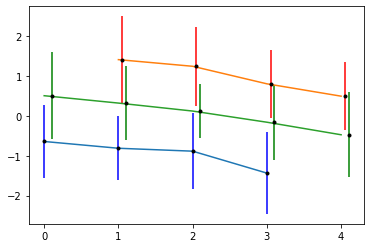

In [34]:
xe = [0,1,2,3]
xa = [1.05,2.05,3.05,4.05]
xn = [0.1,1.1,2.1,3.1,4.1]
plt.errorbar(xe, el, yerr=el_et, fmt='.k',ecolor='b');
plt.errorbar(xa, ap, yerr=ap_et, fmt='.k',ecolor='r');
plt.errorbar(xn, n, yerr=n_et, fmt='.k',ecolor='g');
plt.plot(el2)
plt.plot(ap2)
plt.plot(n)

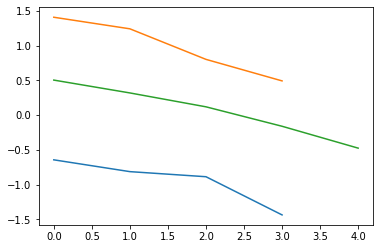

In [35]:
plt.plot(el)
plt.plot(ap)
plt.plot(n)

In [36]:
def meanResponseByAngle(g):
    angles =  calculPositionDisponibles(logs=True,angle=True)
    ms = ['Eloigne','Neutre','Approche']
    mrbd = dict()
    for i in ms:
        mrbd[i]=dict()
        for j in angles:
            mrbd[i][j] = []
    for x in g:
        for y in g[x]:
            for m in g[x][y]:
                for r in g[x][y][m]:
                    d = -1
                    for i in angles:
                        if((x,y) in angles[i]):
                            if('Eloigne' in m):
                                mrbd['Eloigne'][i].append(r)
                            elif('Approche' in m):
                                mrbd['Approche'][i].append(r)
                            else:
                                mrbd['Neutre'][i].append(r)
    for i in ms:
        for j in angles:
            if(len(mrbd[i][j]) != 0):
                mrbd[i][j] = round(sum(mrbd[i][j])/len(mrbd[i][j]),2)
    return mrbd

In [37]:
meanResponseByAngle(g)

{'Eloigne': {0.0: -0.9,
  30.0: -0.94,
  60.0: -0.97,
  90.0: -0.91,
  120.0: -1.08,
  150.0: -0.92,
  180.0: -0.81},
 'Neutre': {0.0: 0.02,
  30.0: 0.07,
  60.0: 0.04,
  90.0: 0.25,
  120.0: -0.21,
  150.0: 0.23,
  180.0: -0.02},
 'Approche': {0.0: 1.02,
  30.0: 0.84,
  60.0: 1.02,
  90.0: 1.18,
  120.0: 0.88,
  150.0: 1.05,
  180.0: 0.85}}

In [38]:
def classResponseMvm(g,reduced = False,restrictedDistance = -1,restrictedAngle = -1):
    mouvements = ['Eloignement Droite','Eloignement','Eloignement Gauche','Gauche','Droite','Approche Gauche','Approche','Approche Droite']
    dRM = dict()
    if(restrictedAngle < 10 and restrictedAngle != -1):
        restrictedAngle*=30
    angles =  calculPositionDisponibles(logs=True,angle=True)
    dists =  calculPositionDisponibles(logs=True)
    for i in mouvements:
        dRM[i]=dict()
        for j in range(-3,4):
            dRM[i][j]=0
    for x in g.keys():
        for y in g[x].keys():
            allowed = False
            if(restrictedAngle != -1):
                if(type(restrictedAngle) == list):
                    for i in restrictedAngle:
                        if((x,y) in angles[i]):
                            allowed = True
                else:
                    if((x,y) in angles[restrictedAngle]):
                        allowed = True
            elif(restrictedDistance != -1):                
                if(type(restrictedDistance) == list):
                    for i in restrictedDistance:
                        if((x,y) in dists[i]):
                            allowed = True
                else:
                    if((x,y) in dists[restrictedDistance]):
                        allowed = True                
            else:
                allowed = True
            if(allowed):    
                for m in mouvements:
                    for r in g[x][y][m]:
                        if(-3<= r and r <= 3):
                            dRM[m][r]+=1
    if(reduced):
        dRMr = dict()
        for i in ['Approche','Neutre','Eloigne']:
            dRMr[i]=dict()
            for j in range(-1,2):
                dRMr[i][j]=0
        for i in dRM:
            for j in range(-3,4):
                jind = 10
                if(j < 0):
                    jind = -1
                elif(j > 0):
                    jind = 1
                else:
                    jind = 0
                if('Approche' in i):
                    dRMr['Approche'][jind]+=dRM[i][j]
                elif('Eloigne' in i):
                    dRMr['Eloigne'][jind]+=dRM[i][j]
                else:
                    dRMr['Neutre'][jind]+=dRM[i][j]
        dRM=dRMr
    for i in dRM:
        s = 0
        for j in dRM[i]:
            s+=dRM[i][j]
        
        for j in dRM[i]:
            if(s!=0):
                dRM[i][j]=round(dRM[i][j]/s*100)
    
    return dRM

In [39]:
def studyClassResponseMvm(g,typeComp="Distance",compareTo = [],compared = -1,reduced = False):
    rD = -1
    rA = -1
    c = []
    cTo = []
    if(typeComp == "Distance"):
        c = classResponseMvm(g,reduced = reduced, restrictedDistance = compared)
        cTo = classResponseMvm(g,reduced = reduced, restrictedDistance = compareTo)
    else:
        c = classResponseMvm(g,reduced = reduced, restrictedAngle = compared)
        cTo = classResponseMvm(g,reduced = reduced, restrictedAngle = compareTo)
    diff = dict()
    for i in c.keys():
        diff[i]=dict()
        for j in c[i].keys():
            diff[i][j]=cTo[i][j]-c[i][j]
    return diff

In [40]:
crm = classResponseMvm(g,reduced = False)
crm

{'Eloignement Droite': {-3: 7, -2: 22, -1: 37, 0: 27, 1: 6, 2: 1, 3: 0},
 'Eloignement': {-3: 5, -2: 18, -1: 45, 0: 28, 1: 3, 2: 1, 3: 0},
 'Eloignement Gauche': {-3: 5, -2: 24, -1: 40, 0: 26, 1: 5, 2: 0, 3: 0},
 'Gauche': {-3: 2, -2: 4, -1: 15, 0: 56, 1: 18, 2: 4, 3: 1},
 'Droite': {-3: 2, -2: 4, -1: 14, 0: 54, 1: 17, 2: 6, 3: 3},
 'Approche Gauche': {-3: 0, -2: 1, -1: 5, 0: 28, 1: 35, 2: 24, 3: 6},
 'Approche': {-3: 0, -2: 1, -1: 2, 0: 36, 1: 32, 2: 22, 3: 7},
 'Approche Droite': {-3: 0, -2: 1, -1: 4, 0: 23, 1: 41, 2: 20, 3: 11}}

In [41]:
classResponseMvm(g,reduced = True,restrictedDistance = 4)

{'Approche': {-1: 10, 0: 41, 1: 49},
 'Neutre': {-1: 34, 0: 55, 1: 10},
 'Eloigne': {-1: 0, 0: 0, 1: 0}}

In [42]:
classResponseMvm(g,reduced = True,restrictedDistance =  [1,2,3])

{'Approche': {-1: 3, 0: 26, 1: 71},
 'Neutre': {-1: 19, 0: 56, 1: 25},
 'Eloigne': {-1: 71, 0: 25, 1: 4}}

In [43]:
studyClassResponseMvm(g,reduced=True,compareTo=[1,2,3],compared=4)

{'Approche': {-1: -7, 0: -15, 1: 22},
 'Neutre': {-1: -15, 0: 1, 1: 15},
 'Eloigne': {-1: 71, 0: 25, 1: 4}}

In [44]:
def dropUseless(pb):
    drop = []
    for x in pb.keys():
        for y in pb[x].keys():
            for mvm in pb[x][y].keys():
                if(pb[x][y][mvm] == (0,0)):
                    drop.append((x,y,mvm))
    for i,j,k in drop:
        pb[i][j].pop(k,None)
    drop=[]
    for x in pb.keys():
        for y in pb[x].keys():
            if(pb[x][y] == {}):
                drop.append((x,y))
    for i,j in drop:
        pb[i].pop(j,None)
    drop=[]
    for x in pb.keys():
        if(pb[x] == {}):
                drop.append(x)
    for i in drop:
        pb.pop(i,None)
    return pb
def searchProblems(mRep):
    mouvements = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    posDist = calculPositionDisponibles(logs=True)
    resMvm = dict()
    for i in mouvements:
        resMvm[i]=(0,0)
    resDist = dict()
    for i in range(0,6):
        resDist[i]=(0,0)
    pb = dict()
    for d in mRep.keys():
        pb[d]=dict()
        for a in mRep[d].keys():
            dist = -1
            for ii in range(0,len(posDist)):
                for j in posDist[ii]:
                    if(j[0] == d and j[1] == a):
                        dist = ii
            pb[d][a]=dict()
            for mvm in mouvements:
                pb[d][a][mvm]=(0,0)
                v=0
                for i in mRep[d][a][mvm]:
                    bRes= False
                    if('Eloignement' in mvm and i < 0):
                        bRes = True
                    elif('Approche' in mvm and i > 0):
                        bRes = True
                    elif(('Eloignement' not in mvm and 'Approche' not in mvm) and i == 0):
                        bRes = True
                    if(bRes):
                        pb[d][a][mvm]=(pb[d][a][mvm][0]+1,pb[d][a][mvm][1])
                        resMvm[mvm]=(resMvm[mvm][0]+1,resMvm[mvm][1])
                        resDist[dist]=(resDist[dist][0]+1,resDist[dist][1])
                    else:
                        pb[d][a][mvm]=(pb[d][a][mvm][0],pb[d][a][mvm][1]+1)
                        resMvm[mvm]=(resMvm[mvm][0],resMvm[mvm][1]+1)
                        resDist[dist]=(resDist[dist][0],resDist[dist][1]+1)
    pb = dropUseless(pb)
    for x in pb.keys():
        for y in pb[x].keys():
            mean = []
            for mvm in pb[x][y].keys():
                if((pb[x][y][mvm][0]+pb[x][y][mvm][1]) != 0):
                    pb[x][y][mvm]=(pb[x][y][mvm][0],pb[x][y][mvm][1],pb[x][y][mvm][0]/(pb[x][y][mvm][0]+pb[x][y][mvm][1]))
                    mean.append(pb[x][y][mvm][2])
            if(mean != []):
                mean = sum(mean)/len(mean)
                pb[x][y]['Mean'] = round(mean,3)
    for mvm in resMvm.keys():
        if(resMvm[mvm][0]+resMvm[mvm][1] != 0):
            resMvm[mvm]=(resMvm[mvm][0],resMvm[mvm][1],round(resMvm[mvm][0]/(resMvm[mvm][0]+resMvm[mvm][1]),2))
    for d in resDist.keys():
        if(resDist[d][0]+resDist[d][1]!=0):
            resDist[d]=(resDist[d][0],resDist[d][1],round(resDist[d][0]/(resDist[d][0]+resDist[d][1]),2))
    return pb,resMvm,resDist

In [45]:
pb,rM,rD = searchProblems(g)

In [46]:
pb

{0: {-41: {'Gauche': (5, 5, 0.5),
   'Approche': (2, 8, 0.2),
   'Approche Gauche': (10, 0, 1.0),
   'Mean': 0.567},
  -24: {'Eloignement Gauche': (8, 2, 0.8),
   'Gauche': (3, 6, 0.3333333333333333),
   'Eloignement': (6, 4, 0.6),
   'Approche': (9, 1, 0.9),
   'Approche Gauche': (6, 4, 0.6),
   'Mean': 0.647},
  -14: {'Eloignement Gauche': (5, 5, 0.5),
   'Gauche': (7, 3, 0.7),
   'Eloignement': (10, 0, 1.0),
   'Approche': (9, 1, 0.9),
   'Approche Gauche': (7, 3, 0.7),
   'Mean': 0.76},
  -8: {'Eloignement Gauche': (10, 0, 1.0),
   'Gauche': (9, 1, 0.9),
   'Eloignement': (5, 5, 0.5),
   'Approche': (6, 4, 0.6),
   'Approche Gauche': (6, 4, 0.6),
   'Mean': 0.72},
  -5: {'Eloignement Gauche': (3, 7, 0.3),
   'Gauche': (5, 5, 0.5),
   'Eloignement': (4, 6, 0.4),
   'Mean': 0.4},
  5: {'Eloignement Droite': (6, 4, 0.6),
   'Droite': (9, 1, 0.9),
   'Eloignement': (3, 7, 0.3),
   'Mean': 0.6},
  8: {'Eloignement Droite': (2, 8, 0.2),
   'Droite': (8, 2, 0.8),
   'Approche Droite': (8,

In [47]:
rM

{'Eloignement Droite': (159, 81, 0.66),
 'Eloignement Gauche': (165, 75, 0.69),
 'Droite': (160, 138, 0.54),
 'Gauche': (166, 133, 0.56),
 'Approche Droite': (172, 67, 0.72),
 'Eloignement': (191, 89, 0.68),
 'Approche': (171, 109, 0.61),
 'Approche Gauche': (157, 83, 0.65)}

In [48]:
rD

{0: (170, 140, 0.55),
 1: (338, 161, 0.68),
 2: (348, 151, 0.7),
 3: (325, 174, 0.65),
 4: (160, 149, 0.52),
 5: (0, 0)}

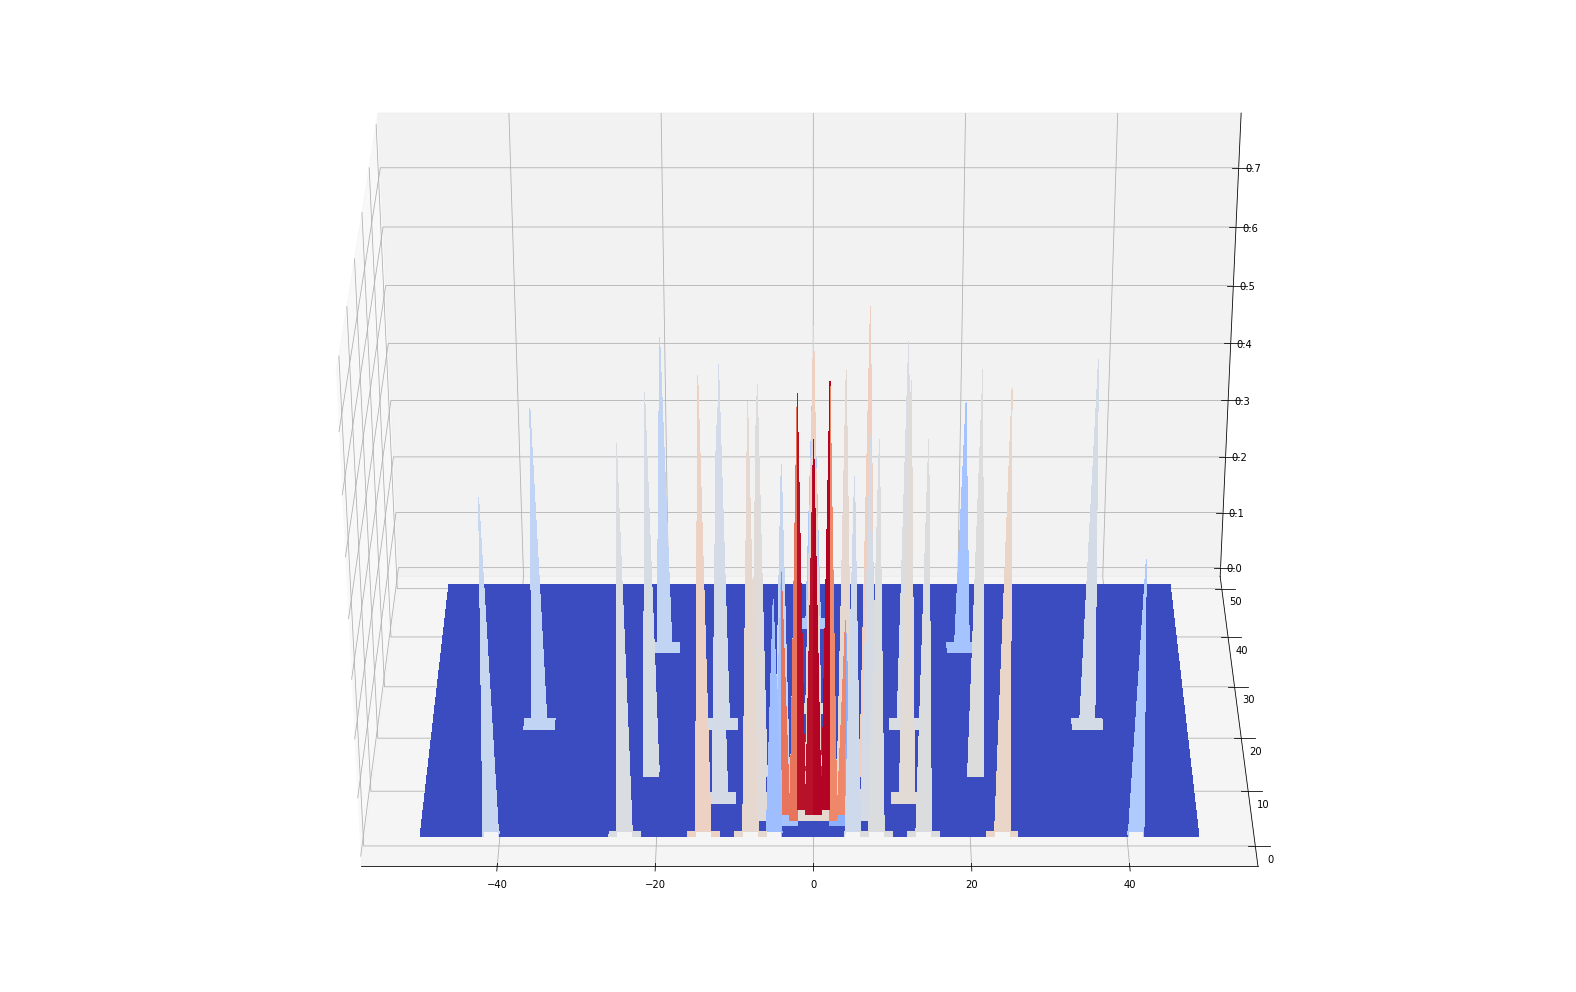

In [49]:
fig = plt.figure(figsize=(28, 18))
ax = fig.gca(projection='3d')
X = np.arange(-50, 50, 1)
Y = np.arange(0,50,1)
X, Y = np.meshgrid(X, Y)
Z = np.asarray(b)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.invert_yaxis()
ii = -90
ax.view_init(elev=30., azim=ii)

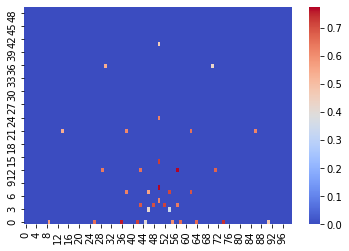

In [50]:
ax = sns.heatmap(b,cmap=colors)
ax.invert_yaxis()

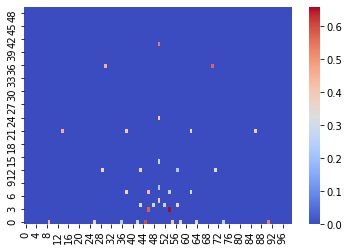

In [51]:
ax = sns.heatmap(m,cmap=colors)
ax.invert_yaxis()

In [52]:
posDist = calculPositionDisponibles(logs=True,posDict=True)
posDist

{0: [(0, -5), (3, -4), (4, -2), (5, 0), (4, 2), (3, 4), (0, 5)],
 1: [(0, -8), (4, -7), (7, -4), (8, 0), (7, 4), (4, 7), (0, 8)],
 2: [(0, -14), (7, -12), (12, -7), (14, 0), (12, 7), (7, 12), (0, 14)],
 3: [(0, -24), (12, -21), (21, -12), (24, 0), (21, 12), (12, 21), (0, 24)],
 4: [(0, -41), (21, -36), (36, -20), (41, 0), (36, 20), (21, 36), (0, 41)]}

In [53]:
def avgResponseMovement(r,avgd = True,dist=False, mouvements = ['Eloignement Droite','Eloignement','Eloignement Gauche','Gauche','Droite','Approche Droite','Approche','Approche Gauche']):
    avg = dict()
    posDist = calculPositionDisponibles(logs=True,posDict=True)
    for m in mouvements:
        avg[m]=[]
        if(dist):
            avg[m]=dict()
            for i in range(0,5):
                avg[m][i]=[]
            for x in r.keys():
                for y in r[x].keys():
                    ind = -1
                    for i in posDist:
                        if((x,y)in posDist[i]):
                            ind = i
                    if(r[x][y][m]!=[]):
                        #print(r[x][y][m])
                        for i in r[x][y][m]:
                            if(ind != -1):
                                avg[m][ind].append(i)
        else:
            for x in r.keys():
                for y in r[x].keys():
                    if(r[x][y][m]!=[]):
                        #print(r[x][y][m])
                        for i in r[x][y][m]:
                            avg[m].append(i)
    avg2 = dict()
    if(avgd):
        if(dist):
            for m in mouvements:
                for i in posDist:
                    if(len(avg[m][i])!=0):
                        avg[m][i]=round(sum(avg[m][i])/len(avg[m][i]),2)
        else:
            for m in mouvements:
                avg[m]=round(sum(avg[m])/len(avg[m]),2)
    else:
        if(dist):
            for m in mouvements:
                avg2[m]=dict()
                for i in posDist:
                    avg2[m][i]=dict()
                    for m2 in range(-3,4):
                        avg2[m][i][m2]=0
                    for val in avg[m][i]:
                        if(val >= -3 and val <= 3):
                            avg2[m][i][val]+=1
            for m in mouvements:
                sumT = dict()
                for m2 in range(-3,4):  
                    sumT[m2] = 0
                for i in posDist:
                    sumA = 0
                    for m2 in range(-3,4):  
                        sumA += avg2[m][i][m2]
                    if(sumA != 0):
                        for m2 in range(-3,4):      
                            avg2[m][i][m2] /= sumA
                            avg2[m][i][m2] = round(avg2[m][i][m2],2)*100
                            sumT[m2]+=sumA
        else:
            #print(avg)
            for m in mouvements:
                avg2[m]=dict()
                for m2 in range(-3,4):
                    avg2[m][m2]=0
                for val in avg[m]:
                    if(val >= -3 and val <= 3):
                        avg2[m][val]+=1
            #print(avg2)
            #AVG
            for m in mouvements:
                sumT = 0
                for m2 in range(-3,4):
                    sumT+=avg2[m][m2]
                for m2 in range(-3,4):
                    avg2[m][m2]/=sumT
                    avg2[m][m2] = round(avg2[m][m2],2)
               
    return avg,avg2

In [54]:
a1,a2 = avgResponseMovement(g,avgd=False,dist=True)
a2

{'Eloignement Droite': {0: {-3: 0.0,
   -2: 18.0,
   -1: 42.0,
   0: 27.0,
   1: 13.0,
   2: 0.0,
   3: 0.0},
  1: {-3: 0.0, -2: 20.0, -1: 35.0, 0: 40.0, 1: 2.0, 2: 3.0, 3: 0.0},
  2: {-3: 5.0,
   -2: 20.0,
   -1: 40.0,
   0: 27.0,
   1: 7.000000000000001,
   2: 2.0,
   3: 0.0},
  3: {-3: 23.0, -2: 32.0, -1: 30.0, 0: 13.0, 1: 2.0, 2: 0.0, 3: 0.0},
  4: {-3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0}},
 'Eloignement': {0: {-3: 1.0,
   -2: 11.0,
   -1: 44.0,
   0: 37.0,
   1: 3.0,
   2: 3.0,
   3: 0.0},
  1: {-3: 0.0,
   -2: 14.000000000000002,
   -1: 54.0,
   0: 27.0,
   1: 4.0,
   2: 0.0,
   3: 0.0},
  2: {-3: 7.000000000000001,
   -2: 16.0,
   -1: 47.0,
   0: 28.999999999999996,
   1: 1.0,
   2: 0.0,
   3: 0.0},
  3: {-3: 11.0, -2: 31.0, -1: 34.0, 0: 20.0, 1: 3.0, 2: 0.0, 3: 0.0},
  4: {-3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0}},
 'Eloignement Gauche': {0: {-3: 3.0,
   -2: 10.0,
   -1: 45.0,
   0: 33.0,
   1: 7.000000000000001,
   2: 2.0,
   3: 0.0},
  1: {-3: 0.0, -2: 25.0, -1: 50.0

In [55]:
a1

{'Eloignement Droite': {0: [-1,
   -1,
   -2,
   0,
   -1,
   0,
   -1,
   -1,
   0,
   0,
   0,
   -2,
   -1,
   0,
   0,
   0,
   -1,
   0,
   -1,
   0,
   0,
   1,
   1,
   0,
   0,
   -2,
   1,
   1,
   0,
   0,
   -2,
   -2,
   -1,
   -1,
   -1,
   0,
   -1,
   -1,
   -1,
   -1,
   -1,
   1,
   1,
   -2,
   -1,
   -1,
   -2,
   1,
   -1,
   -1,
   -1,
   -2,
   -2,
   -2,
   1,
   -1,
   -1,
   -1,
   -2,
   -1],
  1: [0,
   -2,
   -1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   -1,
   -2,
   -2,
   0,
   0,
   -1,
   -2,
   -1,
   -1,
   0,
   -1,
   2,
   -1,
   0,
   0,
   0,
   -1,
   0,
   -1,
   0,
   0,
   -2,
   -1,
   -1,
   0,
   0,
   -2,
   0,
   -1,
   0,
   0,
   -1,
   -1,
   2,
   -2,
   -1,
   -2,
   -1,
   -2,
   1,
   -1,
   -2,
   -2,
   0,
   -1,
   0,
   -2,
   -1,
   -1,
   -1],
  2: [0,
   0,
   0,
   0,
   -1,
   0,
   -1,
   0,
   0,
   0,
   1,
   -1,
   -1,
   0,
   -2,
   0,
   -1,
   -1,
   -1,
   0,
   -1,
   -3,
   -2,
   -2,
   -2,
   -1,
   -2,
 

In [56]:
a2

{'Eloignement Droite': {0: {-3: 0.0,
   -2: 18.0,
   -1: 42.0,
   0: 27.0,
   1: 13.0,
   2: 0.0,
   3: 0.0},
  1: {-3: 0.0, -2: 20.0, -1: 35.0, 0: 40.0, 1: 2.0, 2: 3.0, 3: 0.0},
  2: {-3: 5.0,
   -2: 20.0,
   -1: 40.0,
   0: 27.0,
   1: 7.000000000000001,
   2: 2.0,
   3: 0.0},
  3: {-3: 23.0, -2: 32.0, -1: 30.0, 0: 13.0, 1: 2.0, 2: 0.0, 3: 0.0},
  4: {-3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0}},
 'Eloignement': {0: {-3: 1.0,
   -2: 11.0,
   -1: 44.0,
   0: 37.0,
   1: 3.0,
   2: 3.0,
   3: 0.0},
  1: {-3: 0.0,
   -2: 14.000000000000002,
   -1: 54.0,
   0: 27.0,
   1: 4.0,
   2: 0.0,
   3: 0.0},
  2: {-3: 7.000000000000001,
   -2: 16.0,
   -1: 47.0,
   0: 28.999999999999996,
   1: 1.0,
   2: 0.0,
   3: 0.0},
  3: {-3: 11.0, -2: 31.0, -1: 34.0, 0: 20.0, 1: 3.0, 2: 0.0, 3: 0.0},
  4: {-3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0}},
 'Eloignement Gauche': {0: {-3: 3.0,
   -2: 10.0,
   -1: 45.0,
   0: 33.0,
   1: 7.000000000000001,
   2: 2.0,
   3: 0.0},
  1: {-3: 0.0, -2: 25.0, -1: 50.0

In [57]:
def showResultsByDistance(res,verbose= False):
    mouvements = ['Eloignement Droite','Eloignement Gauche','Droite','Gauche','Approche Droite','Eloignement','Approche','Approche Gauche']
    resDist = dict()
    posDist = calculPositionDisponibles(logs=True)
    for i in posDist:
        resDist[i]=(0,0)
    for x in res.keys():
        for y in res[x].keys():
            for mvm in mouvements:
                for data in res[x][y][mvm]:
                    if(data!=[]):
                        ind = -1
                        for i in range(0,5):
                            if((x,y) in posDist[i]):
                                ind = i
                        
                        reponse = data['Reponse']
                        if(ind != -1):
                            if('Eloignement' in mvm and reponse<0):
                                resDist[ind]=(resDist[ind][0]+1,resDist[ind][1])
                            elif('Approche' in mvm and reponse>0):
                                resDist[ind]=(resDist[ind][0]+1,resDist[ind][1])
                            elif(mvm in ['Droite', 'Gauche'] and reponse==0):
                                resDist[ind]=(resDist[ind][0]+1,resDist[ind][1])
                            else:
                                if(verbose):
                                    print(mvm+" : "+str(reponse))
                                resDist[ind]=(resDist[ind][0],resDist[ind][1]+1)
    for i in resDist:
        resDist[i]=(resDist[i][0],resDist[i][1],resDist[i][0]/(resDist[i][0]+resDist[i][1]))
    return resDist

In [58]:
showResultsByDistance(res)

{0: (170, 140, 0.5483870967741935),
 1: (338, 161, 0.6773547094188377),
 2: (348, 151, 0.6973947895791583),
 3: (325, 174, 0.6513026052104208),
 4: (160, 149, 0.517799352750809)}

In [59]:
aa = [1,2,3]
bb = [1,2,3]
aa += bb

In [60]:
aa

[1, 2, 3, 1, 2, 3]

In [61]:
def etudeCert(sc):
    tplotCert = []
    tplotRes = []
    for subj in sc:
        print(subj)
        plotCert = []
        plotRes = []
        plotDif = []
        for r, sp, val in sc[subj]:
            s = []
            for inp,exp in val:
                if((exp < 4 and inp > 0) or (exp > 6 and inp < 0) or (exp >=4 and exp <=6 and inp == 0)):
                    s.append(1)
                else:
                    s.append(0)
            plotCert.append(r)
            plotRes.append((sum(s)/len(s))*10)
            plotDif.append(abs(r-(sum(s)/len(s))*10))
        if(len(plotCert) > 5):
            plt.plot(plotCert,label ="Certitude")
            tplotCert+=plotCert
            plt.plot(plotRes,label ="Resultat")
            #plt.plot(plotDif,label ="Différence")
            tplotRes+=plotRes
            print("Certitude",plotCert,len(plotCert))
            print("Resultats",plotRes,len(plotRes))
            print("Diff",plotDif,sum(plotDif)/len(plotDif))
            plt.legend()
            plt.show()
        #val = sum(val)/len(val)
        #print(val)
    print("Total")
    plt.plot(tplotCert,label ="Certitudes totales")
    plt.plot(tplotRes,label ="Resultats totaux")
    plt.legend()
    plt.show()
    dif = []
    for i in range(0,len(tplotCert)):
        dif.append(tplotCert[i]-tplotRes[i])
    plt.plot(dif,label ="Diff Cert/res")
    plt.legend()
    plt.show()

Achille
Certitude [8, 5, 7, 7, 4, 7, 3, 7, 8, 7, 10, 1, 8, 7, 7, 7, 7, 10] 18
Resultats [7.0, 6.0, 5.0, 5.0, 5.0, 7.0, 4.0, 9.0, 8.0, 8.0, 5.5, 2.0, 8.0, 6.0, 4.5, 6.0, 5.0, 8.0] 18
Diff [1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 4.5, 1.0, 0.0, 1.0, 2.5, 1.0, 2.0, 2.0] 1.3888888888888888


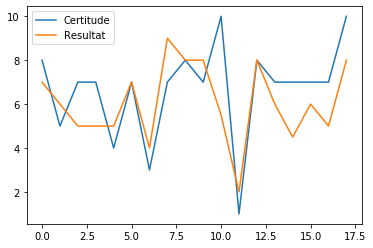

Ambroise
Certitude [7, 8, 8, 8, 8, 7, 9, 7, 7, 7, 8, 7, 7, 8, 6, 7, 8, 8] 18
Resultats [8.0, 8.0, 9.0, 7.0, 8.0, 5.0, 6.0, 5.0, 7.0, 5.0, 7.0, 9.0, 6.0, 7.0, 7.5, 4.0, 8.0, 6.0] 18
Diff [1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 3.0, 2.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.5, 3.0, 0.0, 2.0] 1.3055555555555556


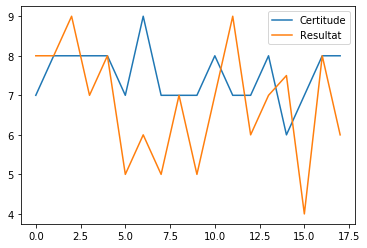

Anais
Certitude [4, 7, 7, 4, 7, 7, 4, 5, 6, 6, 4, 7, 7, 7, 8, 7, 6, 5] 18
Resultats [9.0, 9.0, 10.0, 7.0, 8.0, 7.0, 4.0, 7.0, 8.0, 8.0, 5.5, 8.0, 8.0, 9.0, 7.5, 4.0, 9.0, 5.0] 18
Diff [5.0, 2.0, 3.0, 3.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.5, 1.0, 1.0, 2.0, 0.5, 3.0, 3.0, 0.0] 1.7777777777777777


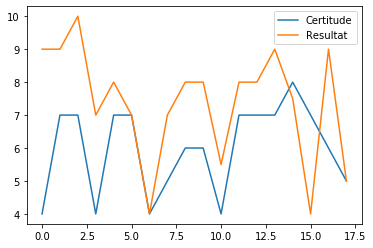

Azilys
Certitude [6, 7, 4, 5, 8, 4, 6, 6, 8, 10, 6, 5, 10, 7, 6, 8, 7, 7] 18
Resultats [8.0, 8.0, 5.0, 5.0, 9.0, 4.0, 5.0, 4.0, 5.0, 6.0, 5.5, 7.0, 7.0, 7.0, 7.5, 9.0, 7.0, 6.0] 18
Diff [2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 0.5, 2.0, 3.0, 0.0, 1.5, 1.0, 0.0, 1.0] 1.3333333333333333


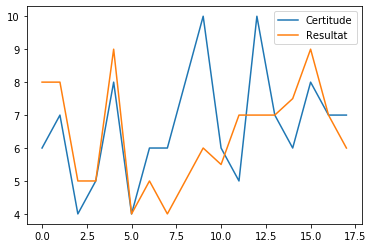

BV
Certitude [8, 9, 9, 9, 9, 9, 4, 9, 7, 9, 9, 5, 9, 8, 9, 9, 8, 9] 18
Resultats [7.0, 6.0, 7.0, 7.0, 7.0, 7.0, 6.0, 7.0, 6.0, 3.0, 7.647058823529411, 6.0, 8.0, 8.0, 7.0, 9.0, 7.0, 7.0] 18
Diff [1.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 6.0, 1.3529411764705888, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0] 1.7418300653594772


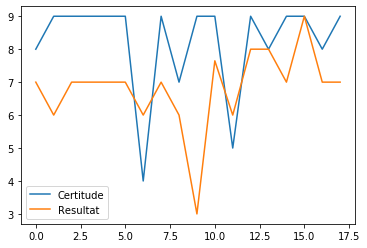

Clement
Jeremie
Manu
Certitude [7, 7, 6, 6, 6, 7, 7, 6, 7, 7, 7, 7, 6, 8, 7, 4, 8, 8, 8, 9, 9] 21
Resultats [7.0, 7.0, 6.0, 8.0, 8.0, 6.0, 8.0, 6.0, 8.0, 6.0, 7.0, 4.0, 7.0, 8.0, 5.0, 7.0, 7.0, 6.0, 2.0, 8.0, 4.0] 21
Diff [0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 3.0, 1.0, 0.0, 2.0, 3.0, 1.0, 2.0, 6.0, 1.0, 5.0] 1.5238095238095237


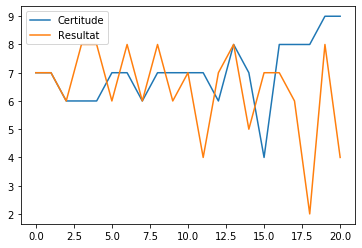

Perrine Seguin
Sandrine7_12
Total


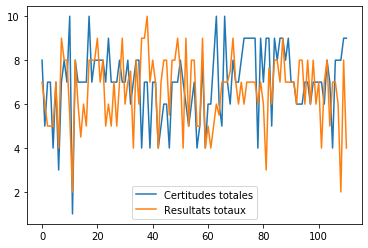

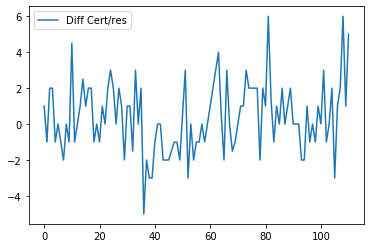

In [62]:
etudeCert(subjectCert)

In [63]:
def meanResponsePosition(g):
    mrp = [[[] for i in range(0,100)] for j in range(0,50)]
    for x in g:
        for y in g[x]:
            for m in g[x][y]:
                for i in g[x][y][m]:
                    mrp[x][y-50].append(i)
    
    for x in range(0,len(mrp)):
        for y in range(0,len(mrp[x])):
                #print(mrp[x][y])
            if(len(mrp[x][y]) != 0):
                mrp[x][y] = sum(mrp[x][y])/len(mrp[x][y])
            else:
                mrp[x][y] = 0
    return mrp

In [64]:
v = meanResponsePosition(g)
v

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.23333333333333334,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.12,
  0,
  0,
  0,
  0,
  0,
  -0.02,
  0,
  0,
  -0.03333333333333333,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -0.3,
  0,
  0,
  0.08,
  0,
  0,
  0,
  0,
  0,
  0.32,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -0.18,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

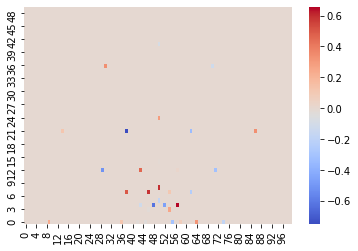

In [65]:

ax = sns.heatmap(v,cmap=colors)
ax.invert_yaxis()

### Temps de réponse

In [66]:
res

{0: {-50: {'Eloignement Droite': [],
   'Eloignement Gauche': [],
   'Droite': [],
   'Gauche': [],
   'Approche Droite': [],
   'Eloignement': [],
   'Approche': [],
   'Approche Gauche': []},
  -49: {'Eloignement Droite': [],
   'Eloignement Gauche': [],
   'Droite': [],
   'Gauche': [],
   'Approche Droite': [],
   'Eloignement': [],
   'Approche': [],
   'Approche Gauche': []},
  -48: {'Eloignement Droite': [],
   'Eloignement Gauche': [],
   'Droite': [],
   'Gauche': [],
   'Approche Droite': [],
   'Eloignement': [],
   'Approche': [],
   'Approche Gauche': []},
  -47: {'Eloignement Droite': [],
   'Eloignement Gauche': [],
   'Droite': [],
   'Gauche': [],
   'Approche Droite': [],
   'Eloignement': [],
   'Approche': [],
   'Approche Gauche': []},
  -46: {'Eloignement Droite': [],
   'Eloignement Gauche': [],
   'Droite': [],
   'Gauche': [],
   'Approche Droite': [],
   'Eloignement': [],
   'Approche': [],
   'Approche Gauche': []},
  -45: {'Eloignement Droite': [],
   'Eloi

In [67]:
def studyReactionTime(r,avg=True,subject = -1,outliers = True,verbose=False):
    mouvements = ['Eloignement Droite','Eloignement','Eloignement Gauche','Droite','Gauche','Approche Droite','Approche','Approche Gauche']
    dMvm = dict()
    for m in mouvements:
        dMvm[m]=[]
    dDist = dict()
    for d in range(0,5):
        dDist[d]=[]
    posDist = calculPositionDisponibles(logs=True)
    
    dCorr = ([],[])
    for x in r:
        for y in r[x]:
            for m in mouvements:
                if(len(r[x][y][m]) > 0 ):
                    for v in r[x][y][m]:
                        if(subject==-1 or subject == v['Subject']):
                            rep = v['Reponse']
                            rt = v['ReactionTime']
                            dMvm[m].append(rt)
                            cor = False
                            if(('Approche' in m and rep>0) or ('Eloigne' in m and rep < 0) or ('Eloigne' not in m and 'Approche' not in m and rep == 0)):
                                cor = True
                            if(cor):
                                dCorr[0].append(rt)
                            else:
                                dCorr[1].append(rt)

                            ind = -1
                            for i in posDist:
                                if((x,y) in posDist[i]):
                                    ind = i
                            if(ind != -1):
                                dDist[ind].append(rt)
    if(not outliers):
        for m in mouvements:
            mean = sum(dMvm[m])/len(dMvm[m])
            outlierLimit = 2*mean
            ind = []
            for i in range(0, len(dMvm[m])):
                if(dMvm[m][i] > outlierLimit):
                    ind.append(i)
            
            for i in range(0,len(ind)):
                del dMvm[m][ind[i]-i]
            if(verbose):
                print(ind,outlierLimit)
    
        for d in range(0,5):
            mean = sum(dDist[d])/len(dDist[d])
            outlierLimit = 2*mean
            ind = []
            for i in range(0, len(dDist[d])):
                if(dDist[d][i] > outlierLimit):
                    ind.append(i)
            
            for i in range(0,len(ind)):
                del dDist[d][ind[i]-i]
            if(verbose):
                print(ind,outlierLimit)
        
        mean = sum(dCorr[0])/len(dCorr[0])
        outlierLimit = 2*mean
        ind = []
        for i in range(0, len(dCorr[0])):
            if(dCorr[0][i] > outlierLimit):
                ind.append(i)

        for i in range(0,len(ind)):
            del dCorr[0][ind[i]-i]
        if(verbose):
                print(ind,outlierLimit)
        
        mean = sum(dCorr[1])/len(dCorr[1])
        outlierLimit = 2*mean
        ind = []
        for i in range(0, len(dCorr[1])):
            if(dCorr[1][i] > outlierLimit):
                ind.append(i)

        for i in range(0,len(ind)):
            del dCorr[1][ind[i]-i]
        if(verbose):
                print(ind,outlierLimit)
    
    if(avg):
        for m in mouvements:
            mean = sum(dMvm[m])/len(dMvm[m])
            s = 0
            for i in dMvm[m]:
                s+=(i-mean)**2
            s = math.sqrt(s/len(dMvm[m]))
            dMvm[m] = (mean,s)
            
        for d in range(0,5):
            mean = sum(dDist[d])/len(dDist[d])
            s = 0
            for i in dDist[d]:
                s+=(i-mean)**2
            s = math.sqrt(s/len(dDist[d]))
            dDist[d] = (mean,s)
            
        s = 0
        mean = sum(dCorr[0])/len(dCorr[0])
        for i in dCorr[0]:
            s+=(i-mean)**2
        s = math.sqrt(s/len(dCorr[0]))
        s2 = 0
        mean = sum(dCorr[1])/len(dCorr[1])
        for i in dCorr[1]:
            s2+=(i-mean)**2
        s2 = math.sqrt(s2/len(dCorr[1]))
        dCorr = ((sum(dCorr[0])/len(dCorr[0]),s),(sum(dCorr[1])/len(dCorr[1]),s2))
    return dMvm,dDist,dCorr

In [68]:
def allReactionTime(res,subjectList,avg=True,outliers=False,verbose=False):
    v = dict()
    for i in subjectList:
        v[i] = dict()
        m,d,c = studyReactionTime(res,subject=i,outliers=outliers,avg=avg,verbose=verbose)
        v[i]['Mouvement']=m
        v[i]['Distance']=d
        v[i]['Resultat']=c
    return v

In [69]:
v = allReactionTime(res,subjectList)

In [70]:
mouvements = ['Eloignement Droite','Eloignement','Eloignement Gauche','Droite','Gauche','Approche Droite','Approche','Approche Gauche']
md = dict()
for m in mouvements:
    md[m]=[]
for i in subjectList:
    for m in mouvements:
        md[m].append(v[i]['Mouvement'][m][0])
print(md)

{'Eloignement Droite': [1144.4545454545455, 2423.875, 945.9047619047619, 1689.0869565217392, 1669.5416666666667, 1545.695652173913, 1243.0, 819.0, 1156.1363636363637, 1270.3636363636363], 'Eloignement': [703.6923076923077, 1920.2592592592594, 910.8846153846154, 1764.2592592592594, 1900.5714285714287, 1352.1538461538462, 857.3703703703703, 752.5, 1099.1923076923076, 1447.4], 'Eloignement Gauche': [730.2272727272727, 2397.2083333333335, 977.2727272727273, 1641.3333333333333, 1851.0869565217392, 1276.4285714285713, 1129.5833333333333, 861.7391304347826, 1250.7826086956522, 1651.391304347826], 'Droite': [953.1034482758621, 2000.0689655172414, 858.9285714285714, 1684.551724137931, 1277.8148148148148, 1235.851851851852, 1147.3793103448277, 860.0344827586207, 754.7407407407408, 1687.1379310344828], 'Gauche': [550.4444444444445, 2008.8214285714287, 723.8571428571429, 1628.2142857142858, 1752.357142857143, 1010.5, 1072.2413793103449, 700.7857142857143, 886.9642857142857, 1198.2142857142858], 'A

Eloignement Droite


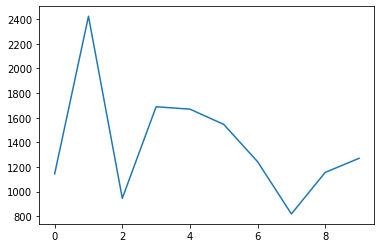

Eloignement


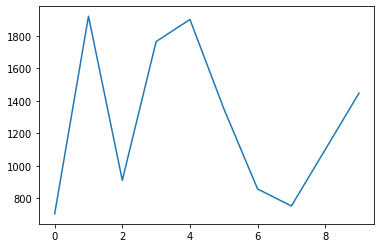

Eloignement Gauche


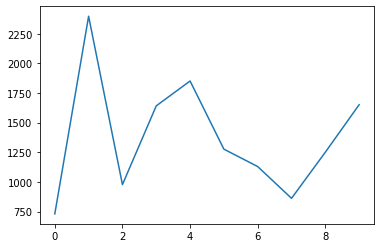

Droite


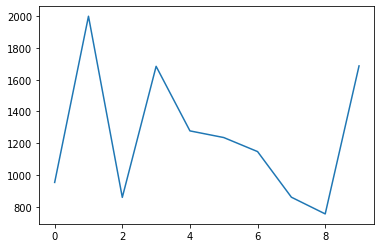

Gauche


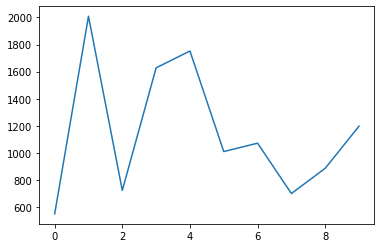

Approche Droite


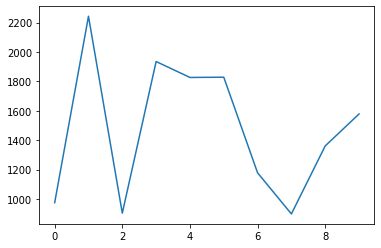

Approche


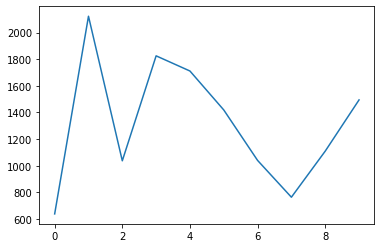

Approche Gauche


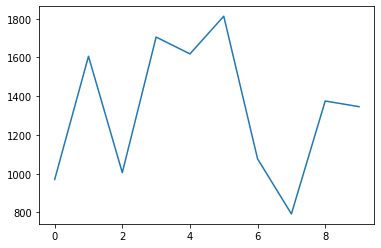

In [71]:
for m in mouvements:
    print(m)
    plt.plot(md[m])
    plt.show()

In [72]:
subjectList

['Achille',
 'Ambroise',
 'Anais',
 'Azilys',
 'BV',
 'Clement',
 'Jeremie',
 'Manu',
 'Perrine Seguin',
 'Sandrine7_12']

In [73]:
#dMvm,dDist,dCorr = studyReactionTime(res,subject='Anais',avg=False,outliers=False,verbose=False)

In [74]:
dMvm

NameError: name 'dMvm' is not defined

In [ ]:
dDist

In [ ]:
dCorr

In [ ]:
def anova(res,comp='Mouvement',emotionnel = False):
    vals = dict()
    dvals = dict()
    mouvements = ['Eloignement Droite','Eloignement','Eloignement Gauche','Gauche','Droite','Approche Gauche','Approche','Approche Droite']
    mvm = ['Eloigne','Approche','Neutre']
    
    dists = [0,1,2,3,4]
    stats = 0
    pvalue = 0
    if(comp == 'Mouvement'):
        for m in mvm:
            vals[m]=[]
        for x in res:
            for y in res[x]:
                for m in mouvements:
                    for v in res[x][y][m]:
                        if('Approche' in m):
                            vals['Approche'].append(v['Reponse'])
                        elif('Eloigne' in m):
                            vals['Eloigne'].append(v['Reponse'])
                        else:
                            vals['Neutre'].append(v['Reponse'])
        
        stats,pvalue = f_oneway(vals['Approche'],vals['Eloigne'],vals['Neutre'])
        for i in mvm:
            dvals[i]=dict()
            for j in mvm:
                dvals[i][j] =0
                if(i!=j):
                    s,p=f_oneway(vals[i],vals[j])
                    if(p<0.05):
                        dvals[i][j]=True,p
                    else:
                        dvals[i][j]=p
    if(comp == 'Distance'):
        posDist = calculPositionDisponibles(logs=True,posDict=True)
        for m in dists:
            vals[m]=[]
        for x in res:
            for y in res[x]:
                ind = -1
                for i in posDist:
                    if((x,y) in posDist[i]):
                        ind = i
                        
                for m in mouvements:
                    for v in res[x][y][m]:
                        vals[ind].append(v['Reponse'])
        
        stats,pvalue = f_oneway(vals[0],vals[1],vals[2],vals[3],vals[4])
        for i in dists:
            dvals[i]=dict()
            for j in dists:
                dvals[i][j] =0
                if(i!=j):
                    s,p=f_oneway(vals[i],vals[j])
                    if(p<0.05):
                        dvals[i][j]=True,p
                    else:
                        dvals[i][j]=p
    return stats,pvalue,vals,dvals

In [ ]:
calculPositionDisponibles(logs=True,posDict=True)

In [ ]:
s,p,vals,dv = anova(res,comp='Mouvement',emotionnel = onlyEmotionnel)
print(s,p)
dv

In [ ]:
sd,pd,valsd,dv = anova(res,comp='Distance')
print(sd,pd)
dv

In [ ]:
emotionnel

In [ ]:
print("Approche")
#sns.boxplot([vals['Approche']])
#plt.show()
print("Eloigne")
#sns.boxplot([vals['Eloigne']])
#plt.show()
print("Neutre")
#sns.boxplot([vals['Neutre']])
#plt.show()
x = [vals['Approche'],vals['Neutre'],vals['Eloigne']]
plt.boxplot(x)
plt.show()
x = [valsd[0],valsd[1],valsd[2],valsd[3],valsd[4]]
plt.boxplot(x)
plt.show()

In [ ]:
print("Approche")
sns.swarmplot(np.array(vals['Approche']))
plt.show()
print("Eloigne")
sns.swarmplot(np.array(vals['Eloigne']))
plt.show()
print("Neutre")
sns.swarmplot(np.array(vals['Neutre']))
plt.show()

In [ ]:
res

In [ ]:
posDist

In [ ]:
dictToDF = dict()
for m in mouvements:
    dictToDF[m]=dict()
    for d in range(0,5):
        dictToDF[m][d]=[]
        
for x in res:
    for y in res[x]:
        for m in mouvements:
            ind = -1
            for i in posDist:
                if((x,y) in posDist[i]):
                    ind = i
            for v in res[x][y][m]:
                dictToDF[m][ind].append(v['Reponse'])
dictToDF

In [ ]:
dT = pd.DataFrame(columns=['Mvm','Dist','Rep'])
ind = 0
for mvm in dictToDF:
    for dist in dictToDF[mvm]:
        for v in dictToDF[mvm][dist]:
            m = -5
            if('Eloigne' in mvm):
                m=-1
            elif('Approche' in mvm):
                m=1
            else:
                m=0
            dT.loc[ind]=[m,dist,v]
            ind+=1

In [ ]:
dT[100:110]

In [ ]:
import statsmodels.api as sma

In [ ]:
dT.info()

dT["Mvm"] = pd.to_numeric(dT["Mvm"])
dT["Dist"] = pd.to_numeric(dT["Dist"])
dT["Rep"] = pd.to_numeric(dT["Rep"])
dT.info()

In [ ]:
model = ols('Rep ~ Mvm + Dist + Mvm:Dist', data=dT).fit()
sm.stats.anova_lm(model, typ=2)